<a href="https://www.kaggle.com/code/johndahlberg/mri-detection?scriptVersionId=240443392" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Object detection on MRI brain images

* Downloading dataset of brain images with bounding boxes
* Plot distribution of image label classes

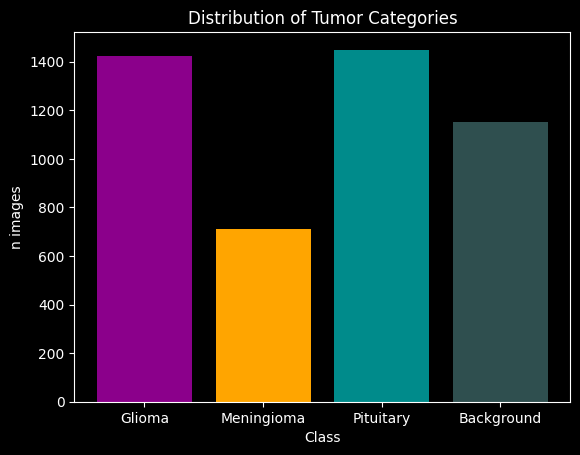

In [1]:
import kagglehub, os
import matplotlib.pyplot as plt

data_set_path = kagglehub.dataset_download("ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes")

# According to mri-for-brain-tumor-with-bounding-boxes dataset labels
class_labels = { 
    0: 'Glioma',
    1: 'Meningioma',
    3: 'Pituitary', 
    2: 'Background',
}

class_colors = {
    0: 'darkmagenta',
    1: 'orange',
    3: 'darkcyan',
    2: 'darkslategray',
}

def count_files_per_subdir(directory):
    n_files_per_subdir = {}
    for root in os.listdir(directory):
        n_files_per_subdir[root] = len([image for image in os.listdir(os.path.join(directory, root, 'images'))])
    return n_files_per_subdir

n_images_per_category = count_files_per_subdir(f'{data_set_path}/Train/')

plt.style.use('dark_background')
plt.bar(class_labels.values(), n_images_per_category.values(), color=list(class_colors.values()))

plt.xlabel("Class")
plt.ylabel("n images")
title = plt.title("Distribution of Tumor Categories")

* Copying all `Train` images and labels into folder `datasets`
* Split `Train` set into `train` and `validation` set
* TODO: Use `datasets/Validation` as `test` set

In [2]:
import numpy as np

root='datasets'
!rm -rf {root}
!mkdir -p {root}/train/images
!mkdir -p {root}/train/labels
!mkdir -p {root}/validation/images
!mkdir -p {root}/validation/labels
!cp -n {data_set_path}/Train/**/images/* {root}/train/images
!cp -n {data_set_path}/Train/**/labels/* {root}/train/labels

traning_validation_split = .75
data_size = int(len(os.listdir(f'{root}/train/images')))
training_data_size = int(data_size * traning_validation_split)
validation_data_size = data_size - training_data_size

print(f'Training data size: {training_data_size}')
print(f'Validation data size: {validation_data_size}')

seed=1
np.random.seed(seed)
def move_data(source_dir, target_dir, n_files):
  all_images = os.listdir(f'{root}/train/images')
  np.random.shuffle(all_images)
  images_to_move = all_images[:validation_data_size]

  for image_name in images_to_move:
      label_name = image_name.replace('.jpg', '.txt')
      label_path = f'{source_dir}/labels/{label_name}'
    
      if os.path.exists(label_path):
          os.rename(f'{source_dir}/images/{image_name}', f'{target_dir}/images/{image_name}')
          os.rename(label_path, f'{target_dir}/labels/{label_name}')
      else:
          print(image_name + ' is missing label ' + label_path + ', ignoring.')

move_data(f'{root}/train', f'{root}/validation', validation_data_size)

Training data size: 3552
Validation data size: 1185


* Define dataset class to init and load data
* Introduce data augmentation 

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ColorJitter
from PIL import Image
from pathlib import Path

BOX_X_INDICES = [0, 2] # To extract x1, x2 from (x1, y1, x2, y2)
BOX_Y_INDICES = [1, 3] # To extract y1, y2 from (x1, y1, x2, y2)

class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, target_image_size, transform=None, data_augmentations=None):
        self.target_image_size = target_image_size
        self.transform = transform
        self.data_augmentations = data_augmentations

        image_paths = []
        label_paths = []

        self.populate(image_paths, images_dir)
        self.populate(label_paths, labels_dir)

        def basename(path):
            return os.path.splitext(os.path.basename(path))[0]

        image_basenames = {basename(path) for path in image_paths}
        label_basenames = {basename(path) for path in label_paths}
        matching_basenames = image_basenames & label_basenames

        self.image_paths = [path for path in image_paths if basename(path) in matching_basenames]
        self.label_paths = [path for path in label_paths if basename(path) in matching_basenames]
        self.background_class_index = 2

    def populate(self, file_paths, dir):
      for dir_path, dir_names, file_names in os.walk(dir):
          for file_name in file_names:
              file_path = os.path.join(dir_path, file_name)
              file_paths.append(file_path)
      file_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def extract_label(self, label_path, image_width, image_height):
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                def scale(center, size, factor):
                    scaled_center = center * factor
                    scaled_size = size * factor
                    half_size = scaled_size / 2
                    return scaled_center - half_size, scaled_center + half_size

                columns = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, columns[:5])
                class_id = int(class_id)
                
                x_min, x_max = scale(x_center, width, image_width)
                y_min, y_max = scale(y_center, height, image_height)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return boxes, labels

    def prune_boxes(self, boxes, labels):
        box_widths = boxes[:, BOX_X_INDICES[1]] - boxes[:, BOX_X_INDICES[0]]
        box_heights = boxes[:, BOX_Y_INDICES[1]] - boxes[:, BOX_Y_INDICES[0]]
        
        min_area = 4 # pixels^2
        valid_size = box_widths * box_heights >= min_area

        x_in_bounds = (boxes[:, BOX_X_INDICES[0]] >= 0) & (boxes[:, BOX_X_INDICES[1]] <= self.target_image_size)
        y_in_bounds = (boxes[:, BOX_Y_INDICES[0]] >= 0) & (boxes[:, BOX_Y_INDICES[1]] <= self.target_image_size)

        valid_boxes = valid_size & x_in_bounds & y_in_bounds
        
        boxes = boxes[valid_boxes]
        labels = labels[valid_boxes]

        return boxes, labels

    def mosaic_augment(self,  image, boxes, labels, index):
        image_width, image_height = image.size

        mosaic_image_size = 2 * self.target_image_size
        mosaic_image_center_y, mosaic_image_center_x = mosaic_image_size // 2, mosaic_image_size // 2

        range_other_images = range(1, len(self)-1)
        indices = ([index] + np.random.choice(range_other_images, size=3)) % range_other_images.stop

        black_rgb = (0, 0, 0)
        mosaic_image = Image.new('RGB', (mosaic_image_size, mosaic_image_size), black_rgb)
        mosaic_boxes = []
        mosaic_labels = []
    
        for corner_idx, idx in enumerate(indices):
            image, boxes, labels = self.extract_image(idx)

            top_left_corner = (
                (corner_idx % 2) * mosaic_image_center_x,
                (corner_idx // 2) * mosaic_image_center_y
            )

            mosaic_image.paste(image, top_left_corner)
    
            if boxes.numel():
                boxes[:, BOX_X_INDICES] = boxes[:, BOX_X_INDICES] + top_left_corner[0]
                boxes[:, BOX_Y_INDICES] = boxes[:, BOX_Y_INDICES] + top_left_corner[1]
    
                mosaic_boxes.append(boxes)
                mosaic_labels.append(labels)

        crop_x = np.random.randint(0, self.target_image_size)
        crop_y = np.random.randint(0, self.target_image_size)
        
        mosaic_image = transforms.functional.crop(
            mosaic_image, crop_y, crop_x, self.target_image_size, self.target_image_size
        )

        if mosaic_boxes:
            mosaic_boxes = torch.cat(mosaic_boxes, dim=0)
            mosaic_labels = torch.cat(mosaic_labels, dim=0)
        else:
            mosaic_boxes = torch.zeros((0, 4))
            mosaic_labels = torch.zeros((0,), dtype=torch.int64)

        mosaic_boxes[:, BOX_X_INDICES] -= crop_x
        mosaic_boxes[:, BOX_Y_INDICES] -= crop_y

        mosaic_boxes, mosaic_labels = self.prune_boxes(mosaic_boxes, mosaic_labels)

        return mosaic_image, mosaic_boxes, mosaic_labels
        
    def scale_and_translate(self, image, boxes):
        image_width, image_height = image.size
            
        scale = float(np.random.uniform(1 - self.data_augmentations.max_scale_variation, 
                                        1 + self.data_augmentations.max_scale_variation))
        scaled_width = int(image_width * scale)
        scaled_height = int(image_height * scale)
        
        max_dx = int(scaled_width * self.data_augmentations.max_translate)
        max_dy = int(scaled_height * self.data_augmentations.max_translate)

        translation_x = np.random.randint(-max_dx, 1 + max_dx)
        translation_y = np.random.randint(-max_dy, 1 + max_dy)
        center = [image_width / 2, image_height / 2]

        image = transforms.functional.affine(image, angle=0, translate=[translation_x, translation_y], scale=scale, center=center, shear=[0.0, 0.0])

        boxes[:, BOX_X_INDICES] = (boxes[:, BOX_X_INDICES] - center[0]) * scale + center[0] + translation_x
        boxes[:, BOX_Y_INDICES] = (boxes[:, BOX_Y_INDICES] - center[1]) * scale + center[1] + translation_y

        return image, boxes
        
    def augment_data(self, image, boxes):
        image_width, image_height = image.size
        
        if np.random.random() < self.data_augmentations.horizontal_flip_probability:
            image = transforms.functional.hflip(image)
            boxes[:, BOX_X_INDICES] = image_width - boxes[:, list(reversed(BOX_X_INDICES))]
            
        if np.random.random() < self.data_augmentations.vertical_flip_probability:
            image = transforms.functional.vflip(image)
            boxes[:, BOX_Y_INDICES] = image_height - boxes[:, list(reversed(BOX_Y_INDICES))]
            
            color_jitter = ColorJitter(self.data_augmentations.max_brightness_jitter,
                                        self.data_augmentations.max_contrast_jitter,
                                        self.data_augmentations.max_saturation_jitter, 
                                        self.data_augmentations.max_hue_jitter)
            image = color_jitter(image)
            
            image, boxes = self.scale_and_translate(image, boxes)

        return image, boxes
        
    def resize(self, image, boxes):
        image_width, image_height = image.size
        image = transforms.functional.resize(image, (self.target_image_size, self.target_image_size))

        resize_scale = torch.tensor([self.target_image_size / image_height,
                                     self.target_image_size / image_width] * 2)
        boxes = boxes * resize_scale
        
        return image, boxes
        
    def pre_process_image(self, image, boxes):
        if self.data_augmentations is not None:
           image, boxes = self.augment_data(image, boxes)
        image, boxes = self.resize(image, boxes)
        
        return image, boxes

    def extract_image(self, index):
        image = Image.open(self.image_paths[index]).convert("RGB")
        image_width, image_height = image.size

        boxes, labels = self.extract_label(self.label_paths[index], image_width, image_height)
        
        image, boxes = self.pre_process_image(image, boxes)
        boxes, labels = self.prune_boxes(boxes, labels)

        return image, boxes, labels
        
    def __getitem__(self, index):
        image, boxes, labels = self.extract_image(index)

        if self.data_augmentations is not None and np.random.random() < self.data_augmentations.mosaic_probability:
            image, boxes, labels = self.mosaic_augment(image, boxes, labels, index)

        if self.transform:
           image = self.transform(image)
        
        return {'image': image, 'boxes': boxes, 'labels': labels}

def collate_fn(batch):
    images = [item['image'] for item in batch]
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    return {
        'images': torch.stack(images, dim=0),
        'boxes': boxes,
        'labels': labels
    }

Instantiate batch data loaders

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from dataclasses import dataclass

import torch
from numba import cuda

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
    
print('Using device:', device)

@dataclass
class DataAugmentations:
    horizontal_flip_probability: float
    vertical_flip_probability: float
    max_brightness_jitter: float
    max_contrast_jitter: float
    max_saturation_jitter: float
    max_hue_jitter: float
    max_translate: float
    max_scale_variation: float
    mosaic_probability: float

target_image_size = 256

data_augmentations = DataAugmentations(horizontal_flip_probability=.5,
                                       vertical_flip_probability=0., # Upside down images are out of distribution
                                       max_brightness_jitter = .5,
                                       max_contrast_jitter = .2, 
                                       max_saturation_jitter = .7, 
                                       max_hue_jitter = .02,
                                       max_translate=.1, # Ratio of image
                                       max_scale_variation=.5,
                                       mosaic_probability=.8) # To place 4 random images in 2x2 grid and crop
              
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = BrainTumorDataset(images_dir=root+'/train/images',
                                  labels_dir=root+'/train/labels',
                                  target_image_size=target_image_size,
                                  transform=transform,
                                  data_augmentations=data_augmentations)

validation_dataset = BrainTumorDataset(images_dir=root+'/validation/images',
                                       labels_dir=root+'/validation/labels',
                                       target_image_size=target_image_size,
                                       transform=transform,
                                       data_augmentations=None)

# Shuffle validation set once to get variation when plotting, as opposed to consecutive scan images
shuffled_indices = torch.randperm(len(validation_dataset)).tolist()
validation_dataset = Subset(validation_dataset, shuffled_indices) 
    
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

Using device: cuda


Visualize sample data from training and validation set

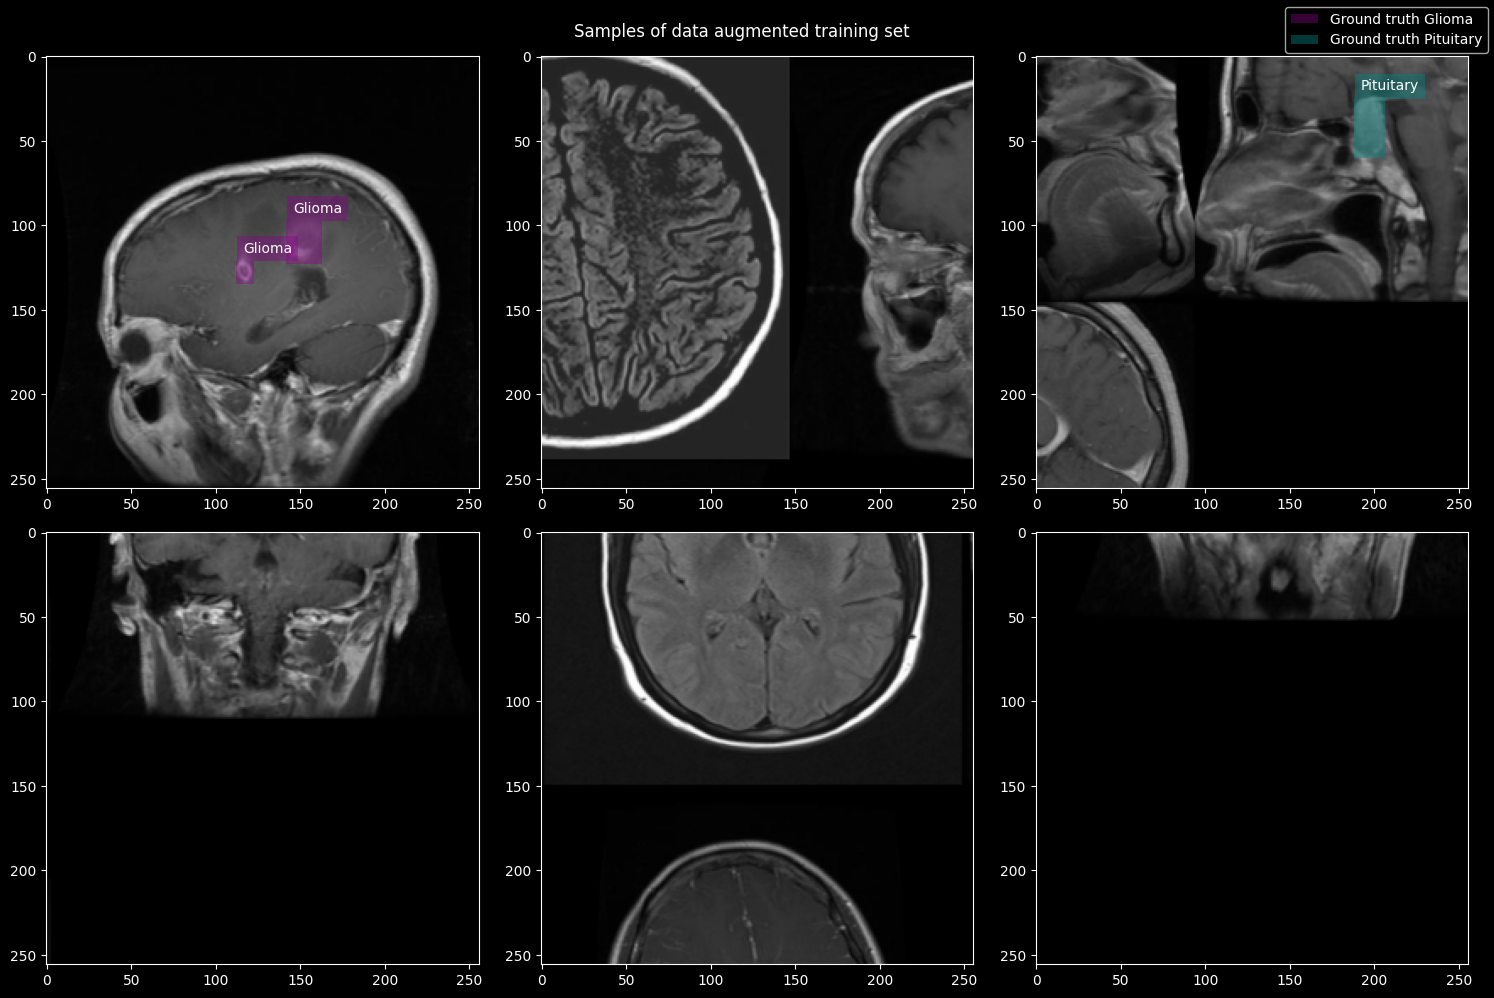

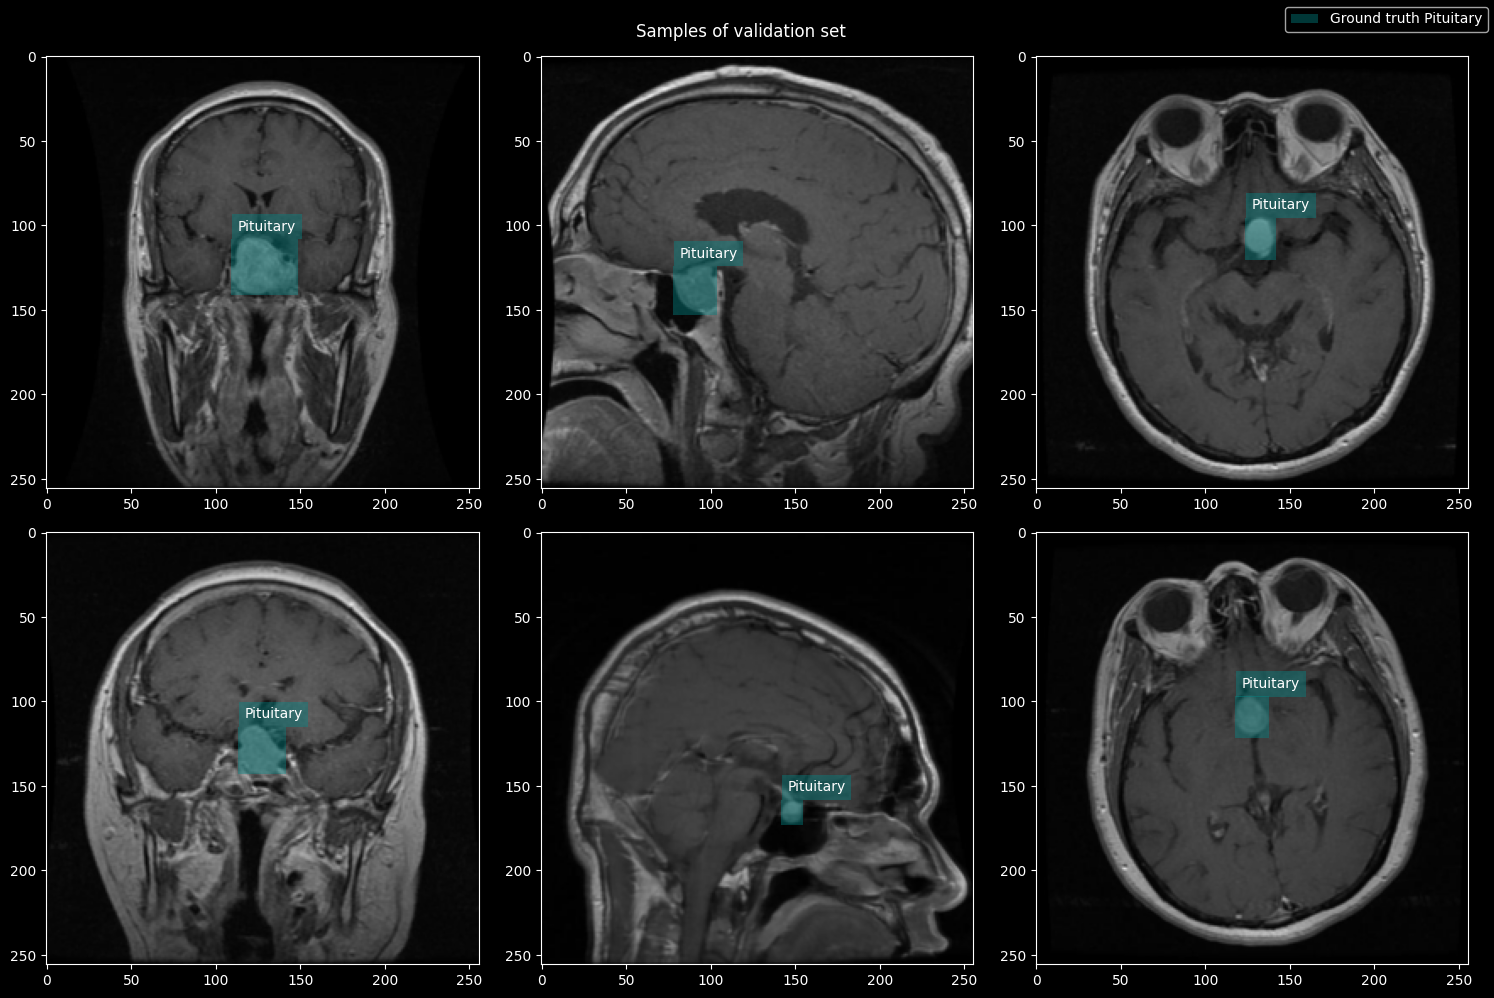

In [5]:
from matplotlib.colors import to_rgba
from collections import OrderedDict, namedtuple

confidence_threshold = .5

Boxes = namedtuple("Boxes", ["xyxy", "conf", "cls"]) # To output on same format as Ultralytics detect call 
Prediction = namedtuple("Prediction", ["boxes"])

def plot_boxes(ax, image, boxes, labels, prediction_confidences=None):
    ax.imshow(image)

    for i, label in enumerate(labels):
        x_min, y_min, x_max, y_max = boxes[i]
        width, height = x_max - x_min, y_max - y_min
        outside_image = (x_min < 0) | (y_min < 0) | (x_max > image.shape[0]) | (y_max > image.shape[1])
            
        if outside_image:
            continue
            
        class_label = class_labels[label.item()]
        #class_label += ' tumor' if class_label != 'Background' else ''
        class_color = class_colors[label.item()]
        legend = class_label
        transparency = .4
        line_width= 3
        bounding_box = plt.Rectangle((x_min, y_min),
                                     width, height,
                                     linewidth=line_width,
                                     label=legend)
        label_text = ax.text(x_min+4, y_min-5, class_label, clip_on=False)
        label_text.set_bbox(dict(facecolor=to_rgba(class_color, alpha=transparency)))
        if prediction_confidences is not None:
            class_keys = list(class_labels.keys())
            label_index = class_keys.index(int(label.item()))
            label_text.set_position((label_text.get_position()[0]+width,
                                     label_text.get_position()[1]+height+(label_index-1)*15))
            confidence_label = f'\nconfidence: {prediction_confidences[i]:.2f}'
            bounding_box.set_edgecolor(class_color)
            bounding_box.set_facecolor('none')
            bounding_box.set_label('Predicted ' + legend)
            label_text.set_text(class_label + confidence_label)
            label_box = label_text.get_bbox_patch()
            label_box.set_edgecolor(class_color)
            label_box.set_facecolor('none')
            label_box.set_linewidth(line_width)  
        else:
            bounding_box.set_label('Ground truth ' + legend)
            bounding_box.set_edgecolor('none')
            bounding_box.set_facecolor(to_rgba(class_color, alpha=transparency))
            label_box = label_text.get_bbox_patch()
            label_box.set_edgecolor('none')
        ax.add_patch(bounding_box)


def add_legends(fig):
    box_legends = [ax.get_legend_handles_labels() for ax in fig.axes]
    box_legends, labels = [sum(lol, []) for lol in zip(*box_legends)]
    box_legends = sorted(zip(labels, box_legends), key=lambda x: x[0])  # Sort by label
    labels, box_legends = zip(*box_legends)
    box_labeled_legends = OrderedDict(zip(labels, box_legends))
    fig.legend(box_labeled_legends.values(), box_labeled_legends.keys())


def visualize_data_samples(title, batch, predictions=None):
      n_samples = len(batch['images'])
      cols = int(min(np.ceil(np.sqrt(n_samples)), 3))
      rows = int(min(np.ceil(n_samples / cols), 2))
      fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

      if isinstance(axes, plt.Axes):  
          axes = [axes]
      else:
          axes = axes.flatten() # Handle 1 subplot
          
      plt.suptitle(title)
      n_samples = min(rows * cols, n_samples)

      for i in range(n_samples):
          image = batch['images'][i].permute(1, 2, 0).cpu().numpy()
          boxes = batch['boxes'][i].detach().cpu().numpy()
          labels = batch['labels'][i]
          plot_boxes(axes[i], image, boxes, labels)
          plt.tight_layout()
      if predictions is not None:
          for i in range(min(n_samples, len(predictions))):
              prediction = predictions[i]
              if i > n_samples:
                  break
              if prediction.boxes.xyxy.numel() == 0:
                  continue
                  
              image = batch['images'][i].permute(1, 2, 0).cpu().numpy()
              boxes = prediction.boxes.xyxy.detach().cpu().numpy()
              confidences = prediction.boxes.conf.detach().cpu().numpy()
              classes = prediction.boxes.cls.detach().cpu().numpy()
              plot_boxes(axes[i], image, boxes, classes, confidences)

      add_legends(fig)
      plt.show()

training_batch = next(iter(train_loader))
visualize_data_samples('Samples of data augmented training set', training_batch)
validation_batch = next(iter(validation_loader))
visualize_data_samples('Samples of validation set', validation_batch)

Define size anchors using k-means clustering of unaugmented training data set

In [6]:
from sklearn.cluster import KMeans
gt_boxes = []

anchor_dataset = BrainTumorDataset(images_dir=root+'/train/images',
                                  labels_dir=root+'/train/labels',
                                  target_image_size=target_image_size,
                                  transform=transform,
                                  data_augmentations=None) # To base on original bounding box sizes

anchor_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

for batch in anchor_loader:
    for boxes in batch['boxes']:
        for box in boxes:
            x_min, y_min, x_max, y_max = box.detach().cpu().numpy()
            width, height = x_max - x_min, y_max - y_min
            gt_boxes.append([width, height])

gt_boxes = np.array(gt_boxes)

n_scales = 3
n_anchors_per_level = 3
kmeans = KMeans(n_clusters=n_scales * n_anchors_per_level, n_init='auto', random_state=0).fit(gt_boxes)
anchors = torch.tensor(kmeans.cluster_centers_ / target_image_size, dtype=torch.float32)
areas = anchors[:, 0] * anchors[:, 1]
sorted_indices = torch.argsort(areas)
anchors = anchors[sorted_indices]
anchors = anchors.view(n_scales, n_anchors_per_level, 2)

print('Anchors:', anchors)

Anchors: tensor([[[0.0663, 0.0603],
         [0.1073, 0.0832],
         [0.1004, 0.1180]],

        [[0.1414, 0.1443],
         [0.1951, 0.1922],
         [0.2624, 0.2823]],

        [[0.7651, 0.6313],
         [0.6283, 0.7759],
         [0.7267, 0.8742]]])


Define and instantiate object detection model, inspired by YOLO5

In [7]:
import torch
import torch.nn as nn
from torchvision.ops import box_iou

def autopad(kernel_size, padding=None):
    if padding is None:
        padding = kernel_size // 2 if isinstance(kernel_size, int) else [x // 2 for x in kernel_size]
        
    return padding

class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=None):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, autopad(kernel_size, padding), groups=1, dilation=1, bias=False)
        self.batchNorm = nn.BatchNorm2d(out_channels)
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(self.batchNorm(self.conv(x)))

    def forward_fuse(self, x):
        return self.act(self.conv(x))


class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, shortcut=True, expansion=.5):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        self.convolution1 = Conv(in_channels, hidden_channels)
        self.convolution2 = Conv(hidden_channels, out_channels, kernel_size=3)
        self.shortcut = shortcut and in_channels == out_channels

    def forward(self, x):
        return x + self.convolution2(self.convolution1(x)) if self.shortcut else self.convolution2(self.convolution1(x))


class C3(nn.Module):
    def __init__(self, in_channels, out_channels, n_bottle_necks=1, shortcut=True, expansion=.5):
        super().__init__()
        hidden_channels = int(out_channels * expansion)
        self.convolution1 = Conv(in_channels, hidden_channels)
        self.convolution2 = Conv(in_channels, hidden_channels)
        self.convolution3 = Conv(2 * hidden_channels, out_channels)
        self.m = nn.Sequential(*(Bottleneck(hidden_channels, hidden_channels, shortcut, expansion=1.) for _ in range(n_bottle_necks)))

    def forward(self, x):
        return self.convolution3(torch.cat((self.m(self.convolution1(x)), self.convolution2(x)), dim=1))

class SPPF(nn.Module):
    def __init__(self, in_channels, out_channels, k=5):
        super().__init__()
        hidden_channels = in_channels // 2
        self.convolution1 = Conv(in_channels, hidden_channels)
        self.convolution2 = Conv(hidden_channels * 4, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=k, stride=1, padding=k // 2)

    def forward(self, x):
        x0 = self.convolution1(x)
        x1 = self.max_pool(x0)
        x2 = self.max_pool(x1)
        
        return self.convolution2(torch.cat((x0, x1, x2, self.max_pool(x2)), dim=1))

class CrossStagePartialDarkNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_map_indices = [4, 6, 9]
        self.layers = nn.Sequential(
            Conv(3, 32, 6, 2, 2),
            Conv(32, 64, 3, 2),
            C3(64, 64, 1),
            Conv(64, 128, 3, 2),
            C3(128, 128, 2),
            Conv(128, 256, 3, 2),
            C3(256, 256, 3),
            Conv(256, 512, 3, 2),
            C3(512, 512, 1),
            SPPF(512, 512, 5)
        )

    def forward(self, x):
        feature_maps = []
        for i, layer in enumerate(self.layers):
            x = layer(x)
        
            if i in self.feature_map_indices:
                feature_maps.append(x)

        return feature_maps

class PathAggregationNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution0 = Conv(512, 256, 1, 1)
        self.up_scale = nn.Upsample(scale_factor=2, mode='nearest')
        self.c3_0 = C3(512, 256, 1, shortcut=False)
        self.convolution1 = Conv(256, 128, 1, 1)
        self.c3_1 = C3(256, 128, 1, shortcut=False)
        self.convolution2 = Conv(128, 128, 3, 2)
        self.c3_2 = C3(256, 256, 1, shortcut=False)
        self.convolution3 = Conv(256, 256, 3, 2)
        self.c3_3 = C3(512, 512, 1, shortcut=False)

    def forward(self, x_small_scale, x_mid_scale, x_large_scale):
        y0 = self.convolution0(x_large_scale)
        x = self.up_scale(y0)
        x = torch.cat([x, x_mid_scale], dim=1)
        x = self.c3_0(x)
        y1 = self.convolution1(x)
        x = self.up_scale(y1)
        x = torch.cat([x, x_small_scale], dim=1)
        y_small_scale = self.c3_1(x)
        x = self.convolution2(y_small_scale)
        x = torch.cat([x, y1], dim=1)
        y_mid_scale = self.c3_2(x)
        x = self.convolution3(y_mid_scale)
        x = torch.cat([x, y0], dim=1)
        y_large_scale = self.c3_3(x)
        
        return y_small_scale, y_mid_scale, y_large_scale

class Detect(nn.Module):
    def __init__(self, n_box_features, n_anchors_per_scale):
        super().__init__()
        self.n_box_features = n_box_features
        self.n_anchors_per_scale = n_anchors_per_scale
        self.channels = (128, 256, 512)
        self.layers = nn.ModuleList([
            nn.Conv2d(channel, n_anchors_per_scale * n_box_features, 1) for channel in self.channels
        ])

    def forward(self, x):
        predictions = []

        for features, layer in zip(x, self.layers):
            batch_size, _, height, width = features.shape
            prediction = layer(features)
            prediction = prediction.view(batch_size, self.n_anchors_per_scale, self.n_box_features, height, width)
            prediction = prediction.permute(0, 1, 3, 4, 2).contiguous()  # [Batch, Anchors, Height, Width, Features]
            predictions.append(prediction)

        return predictions

class Yolo(nn.Module):
    def __init__(self, n_classes, image_shape, anchors, strides, iou_threshold, anchor_threshold, box_factor, obj_factor, class_factor):
        super(Yolo, self).__init__()
        self.n_classes = n_classes
        self.n_scales = len(strides)
        self.iou_threshold = iou_threshold
        self.anchor_threshold = anchor_threshold
        self.n_anchors_per_scale = len(anchors[0])
        self.anchors = anchors
        self.strides = strides
        self.grid_shapes = [(image_shape[0] // stride, image_shape[1] // stride) for stride in strides]
        self.image_shape = image_shape
        
        self.BOX_DIM = 4
        self.BOX_INDICES = slice(0, self.BOX_DIM)
        self.CONF_DIM = 1
        self.CONFIDENCE_IDX = 4
        self.CLASS_IDX = 5
        self.CLASS_INDICES = slice(self.CLASS_IDX, None)
        self.n_box_features =  self.BOX_DIM + self.CONF_DIM + self.n_classes
        self.n_cell_features = self.n_box_features * self.n_anchors_per_scale

        self.XY_INDICES = slice(0, 2)
        self.XY_MAX_INDICES = slice(2, 4)
        self.SIZE_INDICES = slice(2, 4)
        
        self.box_factor = box_factor
        self.obj_factor = obj_factor
        self.class_factor = class_factor 
        
        self.epsilon = 1e-5
        self.label_smoothed_zero = self.epsilon / (self.n_classes - 1)
        self.label_smoothed_one = 1. - self.epsilon

        self.GRID_BIAS = .5
        self.prediction_range = 1.5 # To predict outside cell

        self.backbone = CrossStagePartialDarkNet()
        self.neck = PathAggregationNetwork()
        self.head = Detect(self.n_box_features, self.n_anchors_per_scale)

        self.apply(self.init_weights)

    # As done by https://arxiv.org/abs/1708.02002
    def init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, Detect):
            target_image_size = self.image_shape[0]
            for layer, stride in zip(module.layers, self.strides):
                bias = layer.bias.view(self.n_anchors_per_scale, -1)
                
                objectiveness_bias = np.log(8 / (target_image_size / stride) ** 2)
                class_bias = np.log(.6 / (self.n_classes - self.label_smoothed_one))
                bias.data[:, self.CONFIDENCE_IDX] += objectiveness_bias
                bias.data[:, self.CLASS_INDICES] += class_bias
                
                layer.bias = torch.nn.Parameter(bias.view(-1), requires_grad=True)

    def forward(self, x):
        feature_maps = self.backbone(x)
        feature_maps = self.neck(*feature_maps)
        x = self.head(feature_maps)
     
        return x

    def normalize_boxes(self, boxes):
        image_height, image_width = self.image_shape
        boxes[..., BOX_X_INDICES] /= image_width
        boxes[..., BOX_Y_INDICES] /= image_height
        
        return boxes
        
    def scale_boxes(self, boxes):
        image_height, image_width = self.image_shape
        boxes[..., BOX_X_INDICES] *= image_width
        boxes[..., BOX_Y_INDICES] *= image_height
        return boxes

    def min_max_to_center_size(self, boxes_min_max):
        centers = (boxes_min_max[..., self.XY_INDICES] + boxes_min_max[..., self.XY_MAX_INDICES]) / 2
        sizes = boxes_min_max[..., self.XY_MAX_INDICES] - boxes_min_max[..., self.XY_INDICES]
        return centers, sizes

    def center_size_to_min_max(self, centers, sizes):
        boxes_min_max = torch.cat([centers - sizes / 2, centers + sizes / 2], dim=-1)
        return boxes_min_max
       
    @torch.amp.autocast(device_type=device.type)  
    def encode_targets(self, ground_truth_boxes, ground_truth_labels):
        all_targets = []

        for img_idx, (boxes, labels) in enumerate(zip(ground_truth_boxes, ground_truth_labels)):
            boxes, labels = boxes.clone().to(device), labels.clone().to(device)

            if len(boxes) == 0:
                continue

            normalized_boxes = self.normalize_boxes(boxes)
            centers, sizes = self.min_max_to_center_size(normalized_boxes)

            batch_size = len(normalized_boxes)
            targets = torch.cat([centers,
                                 sizes,
                                 torch.full((batch_size, 1), img_idx, device=device),
                                 labels.view(-1, 1)], dim=1)
            all_targets.append(targets)

        if len(all_targets) > 0:
            targets = torch.cat(all_targets, dim=0).to(device)
        else:
            targets = torch.empty((0, 6), device=device)

        n_targets = targets.shape[0] 
        matched_target_classes, matched_target_boxes, matched_target_indices, matched_anchors = [], [], [], []
        anchor_target_indices = torch.arange(self.n_anchors_per_scale,
                                             device=device).view(self.n_anchors_per_scale, 1).repeat(1, n_targets)
        anchor_target_indices = anchor_target_indices[..., np.newaxis]
        repated_targets = targets.repeat(self.n_anchors_per_scale, 1, 1)
        targets = torch.cat([repated_targets, anchor_target_indices], dim=-1)

        cell_centers = self.GRID_BIAS * (torch.tensor([[0, 0],
                                                        [1, 0],
                                                        [0, 1],
                                                        [-1, 0],
                                                        [0, -1]], device=device, dtype=targets.dtype)) 

        for i in range(self.n_scales):
            scale_anchors = self.anchors[i]

            BATCH_IDX = 4 
            ANCHOR_IDX = 6

            grid_shape =  torch.tensor(model.grid_shapes[i], device=device)
            scale_targets = targets.clone()
            scale_targets[..., self.XY_INDICES] *= grid_shape
            scale_targets[..., self.SIZE_INDICES] *= grid_shape
            scale_anchors = grid_shape * scale_anchors

            if n_targets > 0:
                size_ratio = scale_targets[..., self.SIZE_INDICES] / scale_anchors[:, np.newaxis]

                similar_ratio_indices = torch.max(size_ratio, 1 / size_ratio).max(2)[0] < self.anchor_threshold

                scale_targets = scale_targets[similar_ratio_indices]  
                center = scale_targets[:, self.XY_INDICES]
                center_from_bottom_right = grid_shape - center
                cell_size_in_grid = 1
                center_x_idx, center_y_idx = ((center % cell_size_in_grid < self.GRID_BIAS) & (center > cell_size_in_grid)).T
                center_from_bottom_right_x_idx, center_from_bottom_right_y_idx = ((center_from_bottom_right % cell_size_in_grid < self.GRID_BIAS) & \
                                                                                  (center_from_bottom_right > cell_size_in_grid)).T
                closest_target_indices = torch.stack((torch.ones_like(center_x_idx),
                                                      center_x_idx,
                                                      center_y_idx, 
                                                      center_from_bottom_right_x_idx,
                                                      center_from_bottom_right_y_idx))

                scale_targets = scale_targets.repeat((len(cell_centers), 1, 1))[closest_target_indices]
                cell_centers_extended = (torch.zeros_like(center)[np.newaxis] + cell_centers[:, np.newaxis])[closest_target_indices]

            else:
                scale_targets = targets[0]
                cell_centers_extended = 0
            
            centers = scale_targets[..., self.XY_INDICES]
            cells = (centers - cell_centers_extended).long()
            box_y_cell_indices, box_x_cell_indices = cells.mT
            box_x_cell_indices = box_x_cell_indices.clamp(0, grid_shape[0] - 1)
            box_y_cell_indices = box_y_cell_indices.clamp_(0, grid_shape[1] - 1)
            
            sizes = scale_targets[..., self.SIZE_INDICES]
            batch_indices = scale_targets[..., BATCH_IDX].long()
            classes = scale_targets[..., self.CLASS_IDX].long()
            anchor_indices = scale_targets[..., ANCHOR_IDX].long().view(-1)
         
            matched_target_indices.append((batch_indices, 
                                           anchor_indices,
                                           box_x_cell_indices,
                                           box_y_cell_indices))
            
            target_box = torch.cat((centers - cells, sizes), dim=1)
            matched_target_boxes.append(target_box)
            matched_anchors.append(scale_anchors[anchor_indices])
            matched_target_classes.append(classes) 
            
        return matched_target_classes, matched_target_boxes, matched_target_indices, matched_anchors
    
    def encode(self, ground_truth_boxes, ground_truth_labels):
        matched_target_classes, matched_target_boxes, matched_target_indices, matched_anchors = self.encode_targets(ground_truth_boxes,
                                                                                                                    ground_truth_labels)
        predictions = []

        label_smoothed_negative_logit = torch.tensor(self.label_smoothed_zero, device=device).logit()
        label_smoothed_positive_logit = torch.tensor(self.label_smoothed_one, device=device).logit()
        
        batch_size = len(ground_truth_boxes)
        for i, grid_shape in enumerate(self.grid_shapes):
            scale_predictions = torch.full((batch_size,
                                  self.n_anchors_per_scale, 
                                  grid_shape[0],
                                  grid_shape[1],
                                  self.n_box_features), 
                                  label_smoothed_negative_logit,
                                  device=device)

            batch_indices, anchor_indices, box_x_cell_indices, box_y_cell_indices = matched_target_indices[i]

            predicted_relative_position = ((matched_target_boxes[i][:, self.XY_INDICES] * self.label_smoothed_one + self.GRID_BIAS) / self.prediction_range).logit()
            scale_predictions[batch_indices, 
                             anchor_indices, 
                             box_x_cell_indices, 
                             box_y_cell_indices, 
                             self.XY_INDICES] = predicted_relative_position

            predicted_relative_size = (torch.log((matched_target_boxes[i][:, self.SIZE_INDICES] * self.label_smoothed_one / matched_anchors[i] + 1e-16)) / self.prediction_range).logit()
            scale_predictions[batch_indices, 
                             anchor_indices, 
                             box_x_cell_indices, 
                             box_y_cell_indices, 
                             self.SIZE_INDICES] = predicted_relative_size

            scale_predictions[batch_indices, 
                             anchor_indices, 
                             box_x_cell_indices, 
                             box_y_cell_indices, 
                             self.CONFIDENCE_IDX] = label_smoothed_positive_logit

            target_classes_one_hot_logit = torch.full((len(matched_target_classes[i]), self.n_classes),
                                                      label_smoothed_negative_logit, device=device)
            target_classes_one_hot_logit[range(len(matched_target_classes[i])), matched_target_classes[i]] = label_smoothed_positive_logit
            scale_predictions[batch_indices, anchor_indices, box_x_cell_indices, box_y_cell_indices, self.CLASS_INDICES] = target_classes_one_hot_logit

            predictions.append(scale_predictions)
            
        return predictions
        
    def decode(self, predictions):
        all_boxes = []
        all_confidences = []
        all_classes = []
        
        for scale_idx, (prediction, grid_shape, anchors) in enumerate(zip(predictions, self.grid_shapes, self.anchors)):
            batch_size = prediction.shape[0]
            grid_height, grid_width = grid_shape
    
            anchors = anchors.view(1, self.n_anchors_per_scale, 1, 1, 2).to(device)

            grid_y, grid_x = torch.meshgrid(
                torch.arange(grid_height, device=prediction.device, dtype=torch.float),
                torch.arange(grid_width, device=prediction.device, dtype=torch.float),
                indexing='ij'
            )

            relative_boxes = prediction[..., model.BOX_INDICES] 
            confidences = prediction[..., model.CONFIDENCE_IDX]
            classes = prediction[..., model.CLASS_INDICES]

            prediction_offsets = relative_boxes[..., self.XY_INDICES].sigmoid()
            prediction_log_sizes = relative_boxes[..., self.SIZE_INDICES].sigmoid()
            
            grid = torch.stack((grid_x, grid_y), dim=-1).view(1, 1, grid_height, grid_width, 2)
            grid_size = torch.tensor([grid_width, grid_height], device=device)

            # Normalize to image
            prediction_centers = (self.prediction_range * prediction_offsets - self.GRID_BIAS + grid) / grid_size 
            prediction_sizes = torch.exp(self.prediction_range * prediction_log_sizes) * anchors

            normalized_pred_boxes = self.center_size_to_min_max(prediction_centers, prediction_sizes)
            scaled_boxes = self.scale_boxes(normalized_pred_boxes)

            n_features = self.n_anchors_per_scale * grid_height * grid_width
            if len(scaled_boxes) > 0:
                all_boxes.append(scaled_boxes.reshape(batch_size, n_features, 4))
                all_confidences.append(confidences.reshape(batch_size, n_features)) 
                all_classes.append(classes.reshape(batch_size, n_features, self.n_classes)) 
            else:
                all_boxes.append(torch.zeros(batch_size, n_features, 4))
                all_confidences.append(torch.zeros(batch_size, n_features)) 
                all_classes.append(torch.zeros(batch_size, n_features, self.n_classes)) 

        all_boxes = torch.cat(all_boxes, dim=1) 
        all_confidences = torch.cat(all_confidences, dim=1)
        all_classes = torch.cat(all_classes, dim=1)
        
        return all_boxes, all_confidences, all_classes

    def predict(self, x):
        with torch.no_grad():
            x = self.forward(x)
            box_coordinates, confidences, classes = self.decode(x)
            
            confidences = nn.functional.sigmoid(confidences)
            classes = classes.argmax(dim=-1)
            batch_size = len(box_coordinates)
            decoded_predictions = []
            for i, (batch_box_coordinates, batch_confidences, batch_classes) in enumerate(zip(box_coordinates,
                                                                                              confidences,
                                                                                              classes)):
                confidence_mask = batch_confidences > confidence_threshold

                batch_box_coordinates = batch_box_coordinates[confidence_mask, :]
                batch_confidences = batch_confidences[confidence_mask]
                batch_classes = batch_classes[confidence_mask]
                batch_confidence_sorted_indices = (-batch_confidences).argsort()
                batch_box_coordinates = batch_box_coordinates[batch_confidence_sorted_indices, :]
                batch_confidences = batch_confidences[batch_confidence_sorted_indices]
                batch_classes = batch_classes[batch_confidence_sorted_indices]
              
                nms_indices = torch.ops.torchvision.nms(batch_box_coordinates,
                                                        batch_confidences,
                                                        self.iou_threshold)

                boxes = Boxes(batch_box_coordinates[nms_indices],
                              batch_confidences[nms_indices],
                              batch_classes[nms_indices])
                decoded_predictions.append(Prediction(boxes))
            
            return decoded_predictions
        
    # https://github.com/Zzh-tju/DIoU-SSD-pytorch/blob/master/utils/box/box_utils.py#L47
    def boxCIoU(self, predicted_box, target_box):
        predicted_centers = predicted_box[:, self.XY_INDICES]
        predicted_sizes = predicted_box[:, self.SIZE_INDICES]
        
        target_centers = target_box[:, self.XY_INDICES]
        target_sizes = target_box[:, self.SIZE_INDICES]
        
        predicted_box = self.center_size_to_min_max(predicted_centers, predicted_sizes)
        target_box = self.center_size_to_min_max(target_centers, target_sizes)
                
        predicted_x1, predicted_y1, predicted_x2, predicted_y2 = predicted_box.chunk(self.BOX_DIM, -1)
        target_x1, target_y1, target_x2, target_y2 = target_box.chunk(self.BOX_DIM, -1)
        
        min_width = (predicted_x2.minimum(target_x2) - predicted_x1.maximum(target_x1)).clamp(0)
        min_height = (predicted_y2.minimum(target_y2) - predicted_y1.maximum(target_y1)).clamp(0)
        intersection = min_width * min_height
        
        predicted_width, predicted_height = predicted_sizes.chunk(2, dim=-1)
        target_width, target_height = target_sizes.chunk(2, dim=-1)
        
        predicted_area = predicted_width * predicted_height 
        target_area =  target_width * target_height
        union = predicted_area + target_area - intersection + self.epsilon
    
        iou = intersection / union
        
        min_width = predicted_x2.maximum(target_x2) - predicted_x1.minimum(target_x1)
        min_height = predicted_y2.maximum(target_y2) - predicted_y1.minimum(target_y1)
        diagonal_squared = min_width ** 2 + min_height ** 2 + self.epsilon
        
        (predicted_x_centroid, predicted_y_centroid) = predicted_centers.chunk(2, dim=-1)

        (target_x_centroid, target_y_centroid) = target_centers.chunk(2, dim=-1)

        rho_squared = (target_x_centroid - predicted_x_centroid) ** 2 + (target_y_centroid - predicted_y_centroid) ** 2
        
        target_angle = torch.atan(target_width / target_height)
        predicted_angle =  torch.atan(predicted_width / predicted_height)
        
        v = (target_angle - predicted_angle) ** 2 * 4 / torch.pi ** 2
        alpha = v / (v - iou + (1 + self.epsilon))
    
        return iou - (rho_squared / diagonal_squared + v * alpha)

    @torch.amp.autocast(device_type=device.type)
    def evaluate_loss(self,
                      predictions,
                      ground_truth_boxes,
                      ground_truth_labels):
       
        class_loss = torch.zeros(1, device=device, dtype=torch.float16)
        box_loss = torch.zeros(1, device=device, dtype=torch.float16)
        objectiveness_loss = torch.zeros(1, device=device, dtype=torch.float16)
        target_classes, matched_target_boxes, matched_target_indices, matched_anchors = self.encode_targets(ground_truth_boxes,
                                                                                     ground_truth_labels)

        scale_factor = [5., 1., .5]
        batch_size = len(ground_truth_boxes)
        for i, scale_predictions in enumerate(predictions):
            batch_indices, anchor_indices, box_x_cell_indices, box_y_cell_indices = matched_target_indices[i]
            target_objetiveness = self.label_smoothed_zero * torch.ones(scale_predictions.shape[:4],
                                                                                   dtype=scale_predictions.dtype,
                                                                                   device=device) 
            n_targets = batch_indices.shape[0]
            if n_targets > 0:
                predicted_coordinates = scale_predictions[batch_indices,
                                                              anchor_indices,
                                                              box_x_cell_indices,
                                                              box_y_cell_indices,
                                                              self.XY_INDICES]
                predicted_sizes = scale_predictions[batch_indices,
                                                          anchor_indices,
                                                          box_x_cell_indices,
                                                          box_y_cell_indices,
                                                          self.SIZE_INDICES]
                predicted_classes = scale_predictions[batch_indices,
                                          anchor_indices,
                                          box_x_cell_indices,
                                          box_y_cell_indices,
                                          self.CLASS_INDICES]
                
                predicted_coordinates = 2 * predicted_coordinates.sigmoid() - self.GRID_BIAS
                predicted_sizes = torch.exp(2 * predicted_sizes.sigmoid()) * matched_anchors[i]
                
                predicted_sizes = predicted_sizes.clamp(min=1e-8, max=1e3)  # Prevent exploding box sizes
    
                predicted_boxes = torch.cat((predicted_coordinates, predicted_sizes), dim=1)
                box_ious = self.boxCIoU(predicted_boxes, matched_target_boxes[i]).squeeze()

                box_loss += (1.0 - box_ious).mean()
                box_ious = box_ious.detach().clamp(0).type(target_objetiveness.dtype)

                iou_sorted_indices = box_ious.argsort()
                batch_indices = batch_indices[iou_sorted_indices]
                anchor_indices = anchor_indices[iou_sorted_indices]
                box_x_cell_indices = box_x_cell_indices[iou_sorted_indices]
                box_y_cell_indices = box_y_cell_indices[iou_sorted_indices]
                box_ious =  box_ious[iou_sorted_indices]
                           
                target_objetiveness[batch_indices, anchor_indices, box_x_cell_indices, box_y_cell_indices] = box_ious

    
                scale_batch_target_classes = torch.full_like(predicted_classes, self.label_smoothed_zero, device=device)
                scale_batch_target_classes[range(n_targets), target_classes[i]] = self.label_smoothed_one
                class_loss += nn.functional.cross_entropy(predicted_classes, scale_batch_target_classes)
    
            objectiveness_loss += scale_factor[i] * nn.functional.binary_cross_entropy_with_logits(scale_predictions[..., self.CONFIDENCE_IDX],
                                                                                                   target_objetiveness)

        loss = self.box_factor * box_loss + self.obj_factor * objectiveness_loss + self.class_factor * class_loss 
        n_detect_layers = len(self.head.layers)
        
        loss *= batch_size / n_detect_layers
        
        return loss

strides = [8, 16, 32]
n_classes = len(class_labels)

iou_threshold = .5
anchor_threshold = 5.
box_factor = 3e-6 * target_image_size ** 2
obj_factor = 1.
class_factor = 6e-3 * n_classes

model = Yolo(n_classes=n_classes,
             image_shape=(target_image_size, target_image_size),
             anchors=anchors.to(device),
             strides=strides,
             iou_threshold=iou_threshold,
             anchor_threshold=anchor_threshold,
             box_factor=box_factor,
             obj_factor=obj_factor,
             class_factor=class_factor).to(device)


n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params:.3e}")

Number of parameters: 7.030e+06


Define loss function

In [8]:
def evaluate(compute_metrics=False):
    with torch.no_grad():
        total_loss = 0.
        for batch in validation_loader:
            validation_images = batch['images'].to(device)
            predictions = model(validation_images)
            ground_truth_boxes = batch['boxes']
            ground_truth_labels = batch['labels']
            
            batch_loss = model.evaluate_loss(predictions,
                                             ground_truth_boxes,
                                             ground_truth_labels)
            
            total_loss += batch_loss.item() / len(validation_images)

        mean_loss = total_loss / len(validation_loader)

        return mean_loss

Define optimizer and scheduler with two phases:
* One warm up phase to linearly increase learing rate
* A second cool down phase to anneal learning rate with a cosine function

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, LambdaLR

max_lr = 2e-1
n_epochs = 150
n_warmup_epochs = 5
div_factor = 25

optimizer = torch.optim.SGD(model.parameters(), lr=max_lr/div_factor, momentum=0.9, weight_decay=5e-4)

scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_loader),
    epochs=n_epochs,
    pct_start=n_warmup_epochs/n_epochs,
    anneal_strategy='cos',
    div_factor=div_factor,
    final_div_factor=1e2,
    base_momentum=.8,
    three_phase=True
)

In [10]:
import gc

scaler = torch.amp.GradScaler()

def plot_learning_curve(training_losses, validation_losses):
    if len(training_losses) > 1 or len(validation_losses) > 1:
        plt.plot(training_losses, label='Training Loss', color='magenta')
        plt.plot(validation_losses, label='Validation Loss', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Learning Curve')
        plt.legend()
        plt.show()

training_losses = []
validation_losses = []
current_epoch = 0
patience = 10
show_progress = False
model_path = './best_model.tar'

def train(n_epochs, current_epoch=0, training_losses=[], validation_losses=[]):
    best_validation_loss = float("inf")
    for current_epoch in range(current_epoch, n_epochs):
        model.train()
        gc.collect()
        torch.cuda.empty_cache() 
        epoch_training_loss = 0.

        if current_epoch < n_warmup_epochs:
            train_loader.mosaic_probability = 1.
        else:
            train_loader.mosaic_probability = (n_epochs - current_epoch) / n_epochs

        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            images = batch['images'].to(device)
            
            with torch.amp.autocast(device_type=device.type):
                predictions = model(images)
                
                ground_truth_boxes = batch['boxes']
                ground_truth_labels = batch['labels']

                batch_loss =  model.evaluate_loss(predictions,
                                                  ground_truth_boxes,
                                                  ground_truth_labels)
                
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()                      
            scheduler.step()

            epoch_training_loss += batch_loss.item() / len(images)
            

        training_loss = epoch_training_loss / len(train_loader)
        training_losses.append(training_loss)
        
        gc.collect()
        torch.cuda.empty_cache() 
        validation_loss = evaluate()
        validation_losses.append(validation_loss)
        
        new_best_model = validation_loss < best_validation_loss
        saving_output = 'Saving new best model.' if new_best_model else ''
        print(f"Epoch {current_epoch}/{n_epochs}, Training Loss: {training_loss:.3e}, Validation Loss: {validation_loss:.3e}. " + saving_output)

        if new_best_model:
            best_validation_loss = validation_loss
            best_epoch = current_epoch
            torch.save({'epoch': best_epoch,
                        'model': model,
                        'training_losses': training_losses,
                        'validation_losses': validation_losses,
                        'training_loss': training_loss,
                        'validation_loss': validation_loss},
                         model_path)

        if show_progress and current_epoch % 10 == 0:
            plot_learning_curve(training_losses, validation_losses)
            validation_batch = next(iter(validation_loader))
            validation_images = validation_batch['images'].to(device).requires_grad_(False)
            validation_predictions = model.predict(validation_images)
            visualize_data_samples('Samples of validation set', validation_batch, validation_predictions)
            
        if current_epoch - best_epoch > patience:
            print(f"Early stopping at epoch {current_epoch}")
            return

In [11]:
train(n_epochs, current_epoch, training_losses, validation_losses)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0/150, Training Loss: 2.596e-01, Validation Loss: 2.190e-01. Saving new best model.
Epoch 1/150, Training Loss: 1.858e-01, Validation Loss: 1.885e-01. Saving new best model.
Epoch 2/150, Training Loss: 1.695e-01, Validation Loss: 1.860e-01. Saving new best model.
Epoch 3/150, Training Loss: 1.653e-01, Validation Loss: 1.769e-01. Saving new best model.
Epoch 4/150, Training Loss: 1.605e-01, Validation Loss: 1.690e-01. Saving new best model.
Epoch 5/150, Training Loss: 1.585e-01, Validation Loss: 1.695e-01. 
Epoch 6/150, Training Loss: 1.561e-01, Validation Loss: 1.625e-01. Saving new best model.
Epoch 7/150, Training Loss: 1.515e-01, Validation Loss: 1.595e-01. Saving new best model.
Epoch 8/150, Training Loss: 1.486e-01, Validation Loss: 1.586e-01. Saving new best model.
Epoch 9/150, Training Loss: 1.441e-01, Validation Loss: 1.572e-01. Saving new best model.
Epoch 10/150, Training Loss: 1.418e-01, Validation Loss: 1.554e-01. Saving new best model.
Epoch 11/150, Training Loss: 1.

* Load and evaluate loss of best model 
* Show learning curve
* Visualize prediction samples

Best model at epoch 129 with Training Loss: 1.149e-01, Validation Loss: 1.181e-01


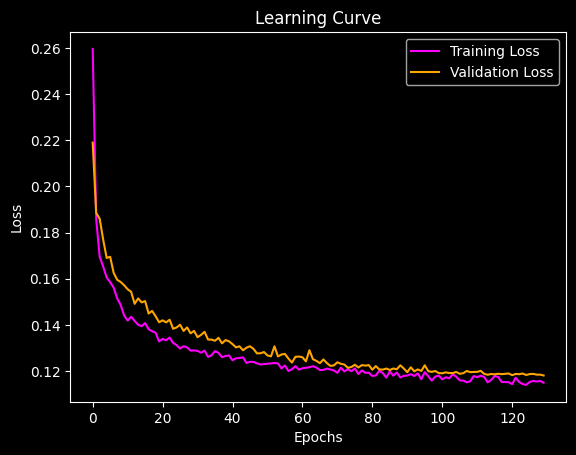

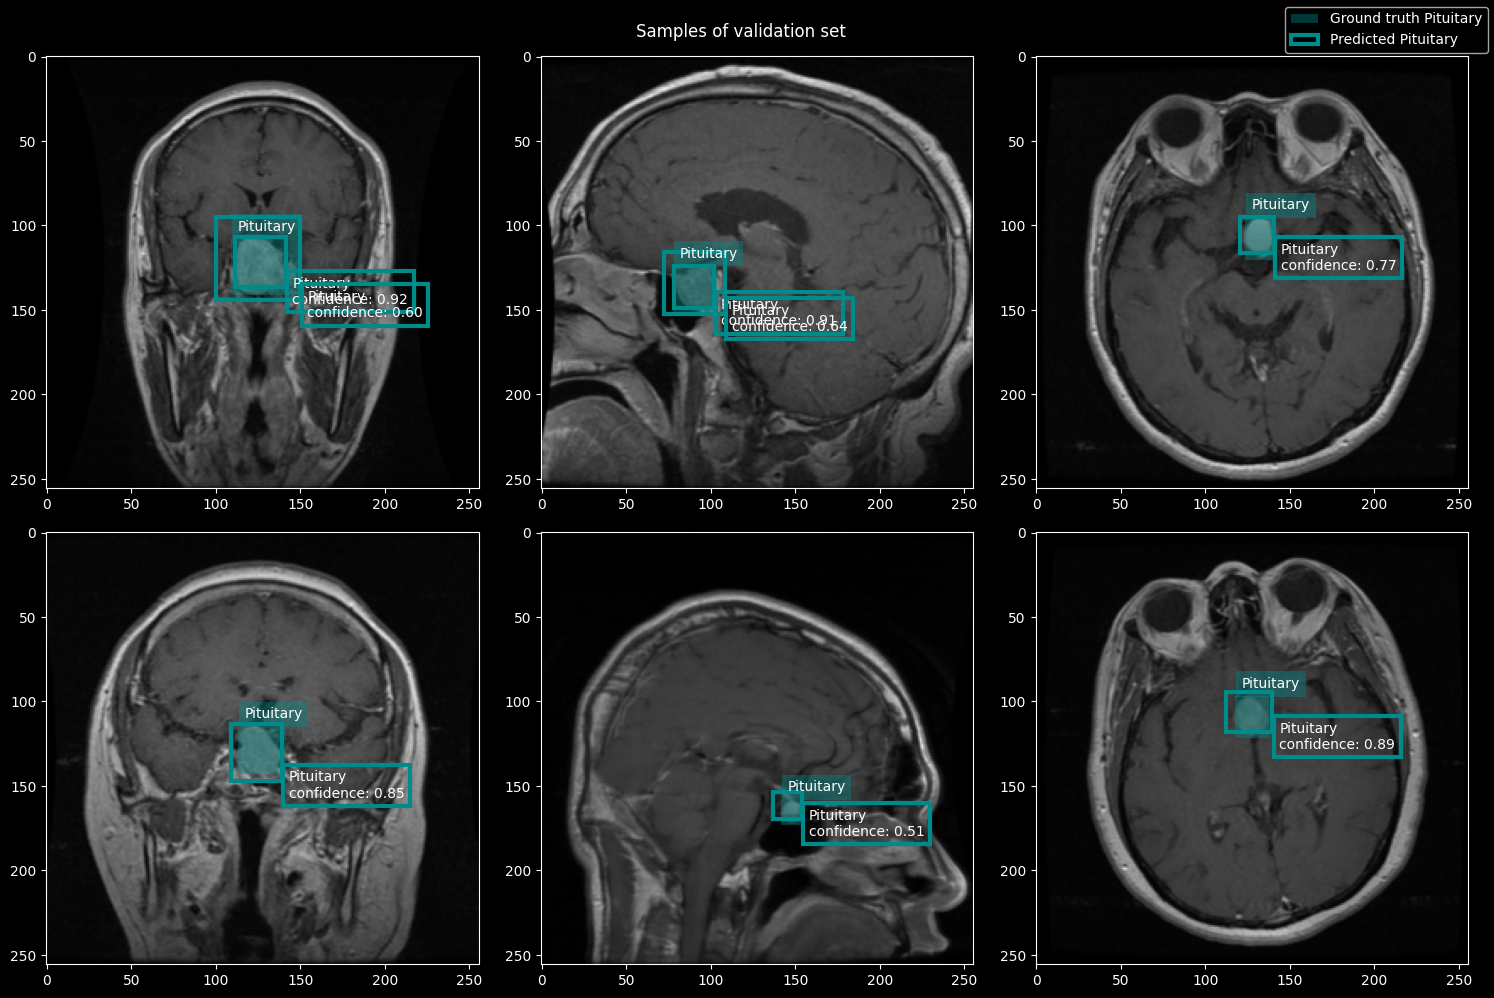

In [12]:
gc.collect()
torch.cuda.empty_cache() 

checkpoint = torch.load(model_path, weights_only=False)

current_epoch = checkpoint['epoch']
model = checkpoint['model']
best_training_loss = checkpoint['training_loss']
best_validation_loss = checkpoint['validation_loss']
training_losses = checkpoint['training_losses']
validation_losses = checkpoint['validation_losses']
print(f"Best model at epoch {current_epoch} with Training Loss: {best_training_loss:.3e}, Validation Loss: {best_validation_loss:.3e}")

plot_learning_curve(training_losses, validation_losses)
validation_batch = next(iter(validation_loader))
validation_images = validation_batch['images'].to(device).requires_grad_(False)

validation_predictions = model.predict(validation_images)
visualize_data_samples('Samples of validation set', validation_batch, validation_predictions)

Calculate evaluation metrics
* Precision
* Recall
* F1 score
* Confusion matrix

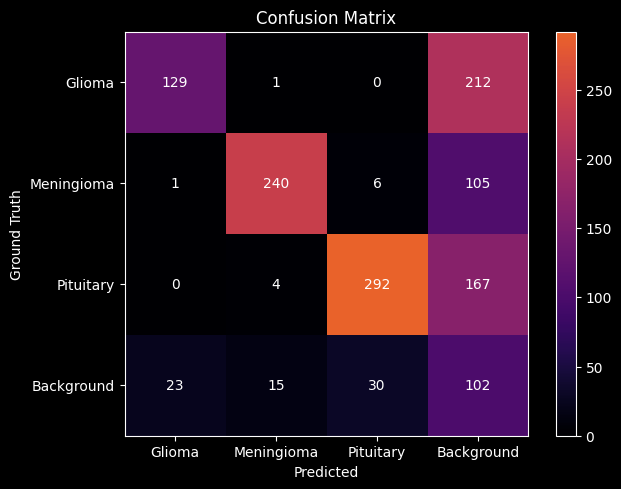

Mean Precision: 0.6306, 
Mean Recall: 0.6144,  
Mean F1 score: 0.6198


In [13]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import linear_sum_assignment

def plot_confusion_matrix(confusion_matrix):
    cmap = plt.get_cmap('inferno')
    colors = cmap(np.linspace(0., .65, cmap.N // 2))
    heatmap = LinearSegmentedColormap.from_list('Upper Half', colors)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=heatmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, list(class_labels.values()))
    plt.yticks(tick_marks, list(class_labels.values()))
    for i in range(n_classes):
        for j in range(n_classes):
            plt.text(j, i, confusion_matrix[i, j], color='white',
                     ha='center', va='center')

    plt.tight_layout()
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted')
    plt.show()


def calculate_scores(true_positives, false_positives, false_negatives):
    epsilon = 1e-6
    precision = true_positives / (true_positives + false_positives + epsilon)
    recall = true_positives / (true_positives + false_negatives + epsilon)
    f1_score = 2 * precision * recall / (precision + recall + epsilon)
    
    return precision, recall, f1_score


def calculate_metrics(pred_boxes, pred_labels, true_boxes, true_labels, iou_threshold):
    iou_matrix = box_iou(true_boxes, pred_boxes)
    cost_matrix = 1 - iou_matrix.cpu().numpy()
    ground_truth_indices, prediction_indices = linear_sum_assignment(cost_matrix)

    confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
    class_keys = list(class_labels.keys())
    class_values = list(class_labels.values())
    background_index = class_values.index('Background')
    matched_true_boxes = set()
    
    for ground_truth_idx, prediction_idx in zip(ground_truth_indices, prediction_indices):
        if iou_matrix[ground_truth_idx, prediction_idx] >= iou_threshold:
            true_label = int(true_labels[ground_truth_idx].item())
            predicted_label = int(pred_labels[prediction_idx].item())
            true_index =  class_keys.index(true_label)
            predicted_index =  class_keys.index(predicted_label)
            confusion_matrix[true_index, predicted_index] += 1
            matched_true_boxes.add(ground_truth_idx)
        else:
            predicted_label = int(pred_labels[prediction_idx].item())
            predicted_index =  class_keys.index(predicted_label)
            confusion_matrix[background_index, predicted_index] += 1

    unmatched_ground_truth_boxes = set(range(len(true_boxes))) - matched_true_boxes
    for ground_truth_idx in unmatched_ground_truth_boxes:
        true_label = int(true_labels[ground_truth_idx].item())
        true_index =  class_keys.index(true_label)
        confusion_matrix[true_index, background_index] += 1

    true_positives = np.sum(np.diag(confusion_matrix))
    false_positives = np.sum(confusion_matrix[:, :background_index]) \
                    - np.sum(np.diag(confusion_matrix[:background_index, :background_index]))
    false_negatives = np.sum(confusion_matrix[:background_index, background_index])
    
    precision, recall, f1_score = calculate_scores(true_positives, false_positives, false_negatives)

    return precision, recall, f1_score, confusion_matrix

def evaluate_metrics(model, iou_threshold):
    with torch.no_grad():
        total_precision = 0.
        total_recall = 0.
        total_f1_score = 0.
        confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)
        for batch in validation_loader:
            validation_images = batch['images'].to(device)
                            
            ground_truth_boxes = batch['boxes']
            ground_truth_labels = batch['labels']
            
            predictions = model.predict(validation_images)
            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction.boxes.xyxy
                predicted_classes = prediction.boxes.cls

                precision, recall, f1_score, batch_confusion_matrix = calculate_metrics(
                    predicted_boxes, predicted_classes, ground_truth_boxes[i].to(device), ground_truth_labels[i].to(device), iou_threshold
                )
                total_precision += precision  / len(validation_images)
                total_recall += recall / len(validation_images)
                total_f1_score += f1_score / len(validation_images)
                confusion_matrix += batch_confusion_matrix

        mean_precision = total_precision /  len(validation_loader)
        mean_recall = total_recall /  len(validation_loader)
        mean_f1_score = total_f1_score /  len(validation_loader)

        return  mean_precision, mean_recall, mean_f1_score, confusion_matrix
        
mean_precision, mean_recall, mean_f1_score, confusion_matrix = evaluate_metrics(model, iou_threshold)
plot_confusion_matrix(confusion_matrix)           
print(f"Mean Precision: {mean_precision:.4f}, \nMean Recall: {mean_recall:.4f},  \nMean F1 score: {mean_f1_score:.4f}")

Configure data paths and train ultralytics yolo5 model on same data for comparison

In [14]:
import yaml, os, logging

def supress_output():
    os.environ["TQDM_DISABLE"]      = "1"
    os.environ["YOLO_DISABLE_TQDM"] = "1"
    os.environ["YOLO_VERBOSE"]      = "False"
    logging.getLogger("ultralytics").setLevel(logging.CRITICAL)

supress_output()

# Comparing with Ultralytics model
# Jocher, G. (2020). YOLOv5 by Ultralytics (Version 7.0) [Computer software]. https://doi.org/10.5281/zenodo.3908559 [Computer software]. https://http://github.com/ultralytics/yolov5
!pip install ultralytics > /dev/null
from ultralytics import YOLO

!rm runs -rf
yolov5n = YOLO('yolov5su.pt')

n_params = sum(p.numel() for p in yolov5n.model.parameters())
print(f"Number of parameters: {n_params:.3e}")

n_classes = len(class_labels)

data = {
    'path': './',
    'train': root+'/train',
    'val': root+'/validation',
    'nc': n_classes,
    'names': list(class_labels.values())
}

with open(f'{root}/data.yaml', 'w') as f:
    yaml.dump(data, f)

results = yolov5n.train(data=root+'/data.yaml',
                        epochs=n_epochs, 
                        imgsz=target_image_size, 
                        batch=64,
                        device=device, 
                        patience=patience,
                        verbose=False,
                        pretrained=False) # To compare models with same assumptions of training from scratch on dataset

100%|██████████| 17.7M/17.7M [00:00<00:00, 219MB/s]


Number of parameters: 9.153e+06


100%|██████████| 755k/755k [00:00<00:00, 24.6MB/s]
2025-05-18 17:39:18,550	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-18 17:39:19,886	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
100%|██████████| 5.35M/5.35M [00:00<00:00, 115MB/s]


Evaluate Ultralytics model with lowest loss on dataset

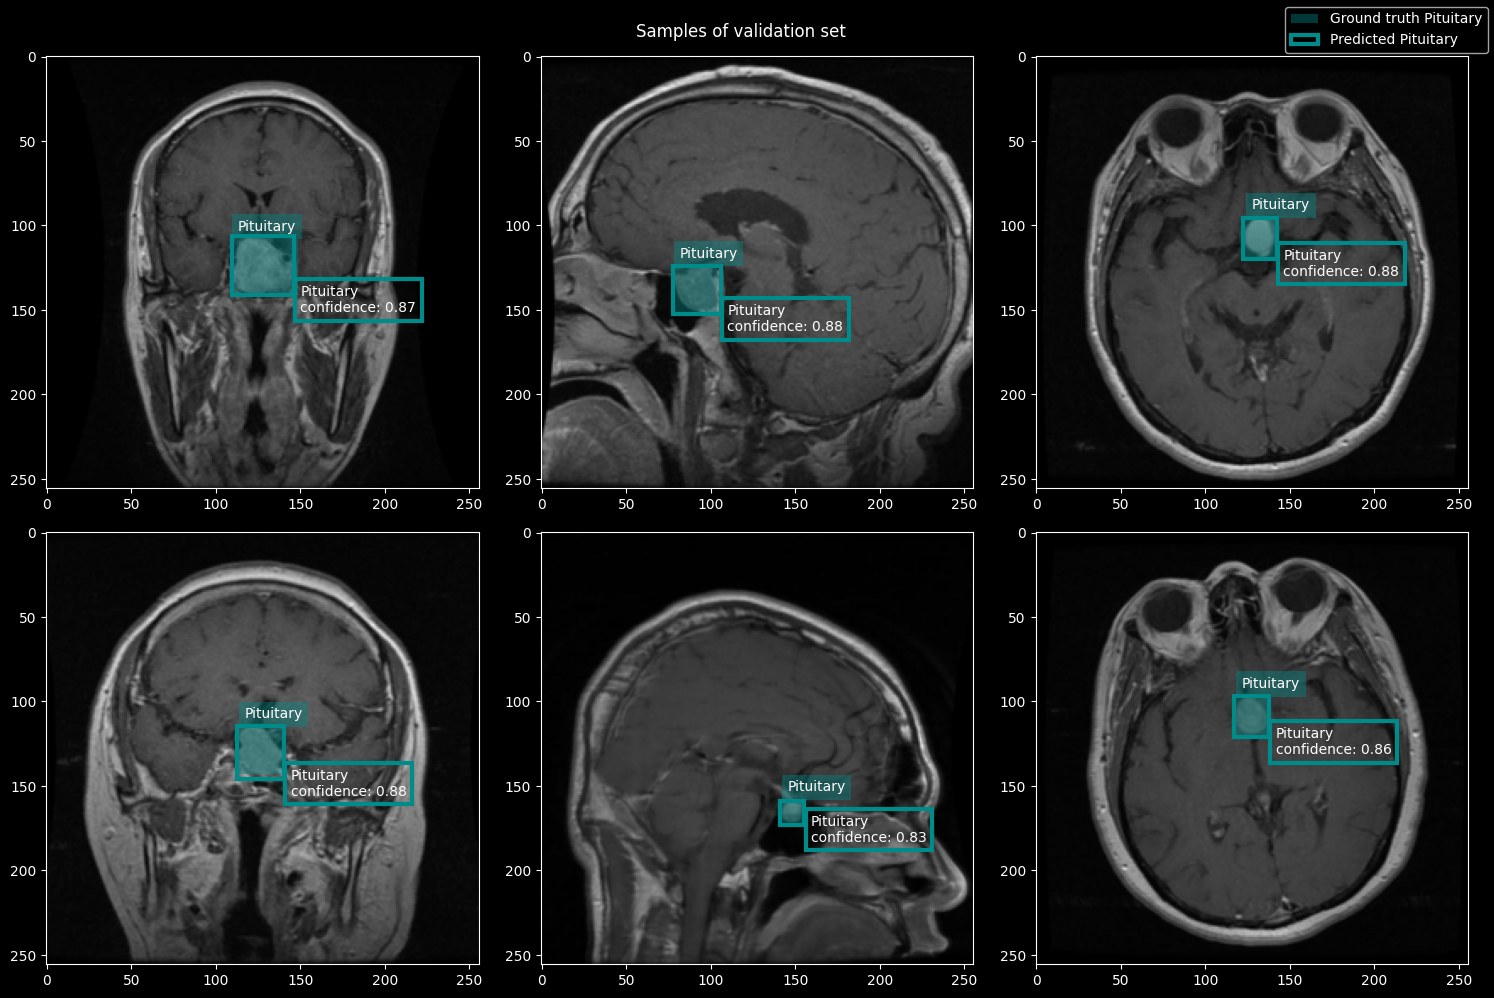

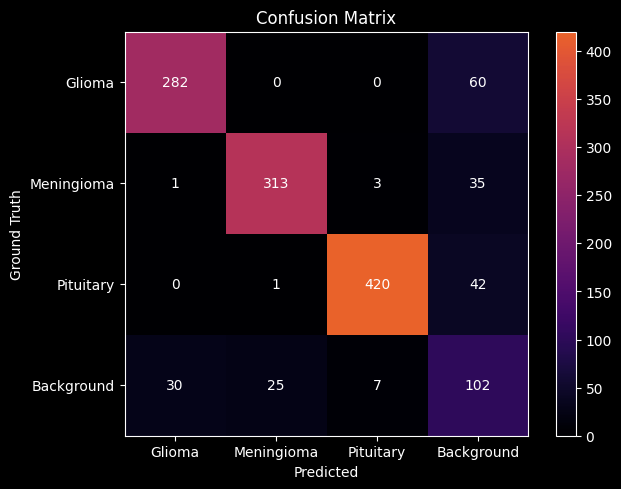

Mean Precision: 0.8791, 
Mean Recall: 0.8623,  
Mean F1 score: 0.8677


In [15]:
best_yolo5_models = !find runs -name best.pt | sort
yolov5nu = YOLO(best_yolo5_models[-1])
yolov5nu.eval()
validation_batch = next(iter(validation_loader))

predictions = yolov5nu.predict(validation_batch['images'].to(device), verbose=False)
visualize_data_samples('Samples of validation set', validation_batch, predictions)

mean_precision, mean_recall, mean_f1_score, confusion_matrix = evaluate_metrics(model=yolov5nu, iou_threshold=iou_threshold)
plot_confusion_matrix(confusion_matrix)           
print(f"Mean Precision: {mean_precision:.4f}, \nMean Recall: {mean_recall:.4f},  \nMean F1 score: {mean_f1_score:.4f}")

Next steps:
* Improve hyper parameter search for better performance
* Pre-train model on other dataset
* Unit test code